Install librairies

In [2]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import librairies

In [19]:
import numpy             as np 
import pandas            as pd 
import opendatasets      as od
import seaborn           as sns
import matplotlib.pyplot as plt

# Load dataset from kaggle

In [9]:
url="https://www.kaggle.com/datasets/ealaxi/paysim1"
od.download(url)

Skipping, found downloaded files in "./paysim1" (use force=True to force download)


# Functions

In [ ]:
def encode_df (df):
    colName = []
    for i in df.columns:
        if (df[i].dtypes == 'object'):
            colName.append(i)
    one_hot_encoded_data = pd.get_dummies(df, columns = colName)
    
    return one_hot_encoded_data

# Exploratory data analysis

In [10]:
df = pd.read_csv("/content/paysim1/PS_20174392719_1491204439457_log.csv")

In [11]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0




*  step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

*    type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

*    amount - amount of the transaction in local currency.

*    nameOrig - customer who started the transaction

*    oldbalanceOrg - initial balance before the transaction

*    newbalanceOrig - new balance after the transaction

*    nameDest - customer who is the recipient of the transaction

*    oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

*    newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

*    isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control of customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

*    isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.


In [15]:
df.describe(include='all')

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6362620,6.362620e+06,6362620,6.362620e+06,6.362620e+06,6362620,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
unique,NaN,5,NaN,6353307,NaN,NaN,2722362,NaN,NaN,NaN,NaN
top,NaN,CASH_OUT,NaN,C1902386530,NaN,NaN,C1286084959,NaN,NaN,NaN,NaN
freq,NaN,2237500,NaN,3,NaN,NaN,113,NaN,NaN,NaN,NaN
mean,2.433972e+02,NaN,1.798619e+05,NaN,8.338831e+05,8.551137e+05,NaN,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,NaN,6.038582e+05,NaN,2.888243e+06,2.924049e+06,NaN,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,NaN,0.000000e+00,NaN,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,NaN,1.338957e+04,NaN,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,NaN,7.487194e+04,NaN,1.420800e+04,0.000000e+00,NaN,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,NaN,2.087215e+05,NaN,1.073152e+05,1.442584e+05,NaN,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00


In [16]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [23]:
df['isFraud'].value_counts(normalize=True)

0    0.998709
1    0.001291
Name: isFraud, dtype: float64

In [25]:
df['isFlaggedFraud'].value_counts(normalize=True)

0    0.999997
1    0.000003
Name: isFlaggedFraud, dtype: float64

**Countplot of each type of transactions**

Text(0.5, 1.0, 'Countplot of different types of transaction (nonFraud and Fraud)')

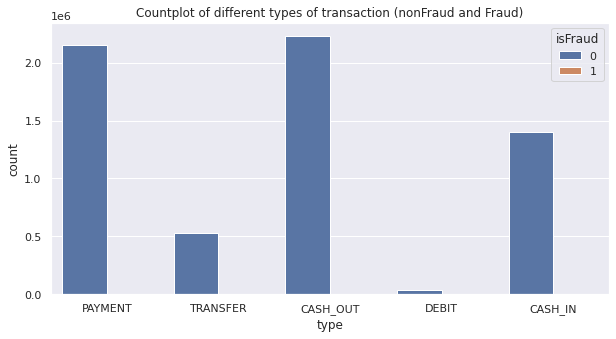

In [28]:
plt.figure(figsize=(10,5))
ax=sns.countplot(x = "type", hue="isFraud", data = df)
plt.title('Countplot of different types of transaction (nonFraud and Fraud)')
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
        

**Proportion of different transactions**

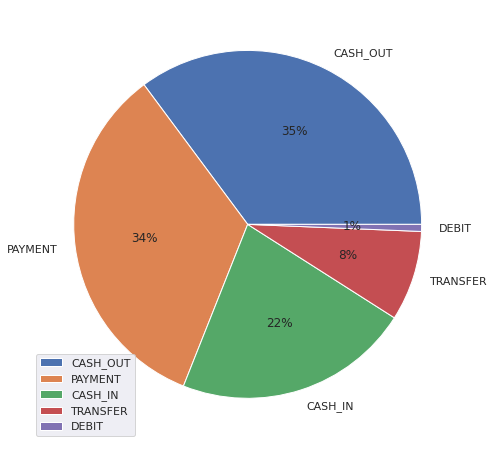

In [30]:
type = df['type'].value_counts()
transaction = type.index
count = type.values

plt.figure(figsize=(8,8))
plt.pie(count, labels=transaction, autopct='%1.0f%%')
plt.legend(loc='lower left')
plt.show()

**Feature encoding**

In [ ]:
df =  encode_df (df)
   

**Feature scaling**

# Prediction

Question: 

1) dois on construire un modèle pour détecter les anomalies ou different modèles chaque type de transaction ?

Pour le premier on envisagera un resampling

2) choix du modèle

# Performance evaluation

# Inference